# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [37]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

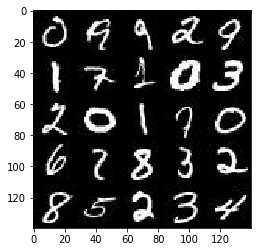

In [38]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

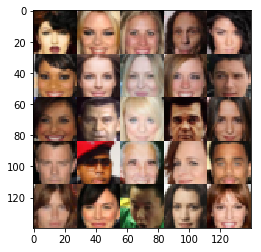

In [39]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [41]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    tf_real_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='tf_real_input')
    tf_z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='tf_z_input')
    tf_lr_rate =  tf.placeholder(dtype=tf.float32, shape=(None), name='tf_lr_rate')
    return tf_real_input, tf_z_input, tf_lr_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [42]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [43]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [44]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [45]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3931... Generator Loss: 0.1102
Epoch 1/2... Discriminator Loss: 0.1844... Generator Loss: 3.0213
Epoch 1/2... Discriminator Loss: 0.1668... Generator Loss: 4.8743
Epoch 1/2... Discriminator Loss: 3.8629... Generator Loss: 0.4640
Epoch 1/2... Discriminator Loss: 0.2668... Generator Loss: 2.0905
Epoch 1/2... Discriminator Loss: 0.2328... Generator Loss: 2.8375
Epoch 1/2... Discriminator Loss: 0.2213... Generator Loss: 2.7569
Epoch 1/2... Discriminator Loss: 3.0950... Generator Loss: 12.6683
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.3387
Epoch 1/2... Discriminator Loss: 0.3616... Generator Loss: 2.1513


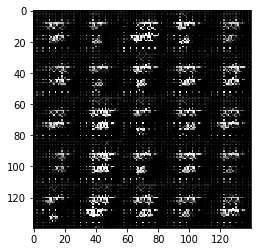

Epoch 1/2... Discriminator Loss: 0.1549... Generator Loss: 3.8445
Epoch 1/2... Discriminator Loss: 0.2600... Generator Loss: 3.2407
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 1.7222
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.0073
Epoch 1/2... Discriminator Loss: 0.4645... Generator Loss: 1.8939
Epoch 1/2... Discriminator Loss: 0.6470... Generator Loss: 2.5383
Epoch 1/2... Discriminator Loss: 0.5392... Generator Loss: 4.9484
Epoch 1/2... Discriminator Loss: 0.4181... Generator Loss: 1.5949
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 4.0295
Epoch 1/2... Discriminator Loss: 4.7343... Generator Loss: 11.2744


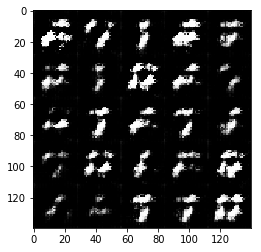

Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 1.7086
Epoch 1/2... Discriminator Loss: 0.6845... Generator Loss: 1.1135
Epoch 1/2... Discriminator Loss: 0.4246... Generator Loss: 3.2149
Epoch 1/2... Discriminator Loss: 1.6965... Generator Loss: 0.6154
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 4.0099
Epoch 1/2... Discriminator Loss: 0.3484... Generator Loss: 1.7227
Epoch 1/2... Discriminator Loss: 0.3819... Generator Loss: 3.0932
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 2.4330
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.1313
Epoch 1/2... Discriminator Loss: 0.5145... Generator Loss: 5.7867


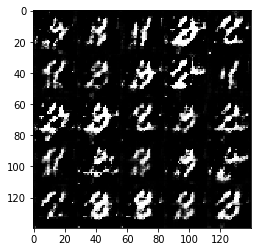

Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 2.0158
Epoch 1/2... Discriminator Loss: 0.8743... Generator Loss: 1.1003
Epoch 1/2... Discriminator Loss: 0.3132... Generator Loss: 2.0487
Epoch 1/2... Discriminator Loss: 0.3548... Generator Loss: 2.2559
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 2.2914
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 8.8915
Epoch 1/2... Discriminator Loss: 2.4686... Generator Loss: 6.2020
Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 1.5392
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 3.1011
Epoch 1/2... Discriminator Loss: 1.6035... Generator Loss: 4.5687


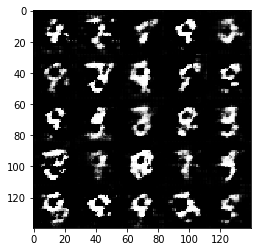

Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 0.4858... Generator Loss: 1.6144
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 2.0488
Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 1.2690
Epoch 1/2... Discriminator Loss: 1.0874... Generator Loss: 1.3903
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 3.7435
Epoch 1/2... Discriminator Loss: 0.7483... Generator Loss: 2.6414
Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 1.7986
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 0.9272


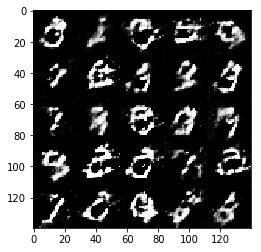

Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 2.0850
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 0.8501
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.0810
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.0434
Epoch 1/2... Discriminator Loss: 0.4802... Generator Loss: 2.0440
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.6541
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 0.5198
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 1.0340
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 1.8909
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 0.9030


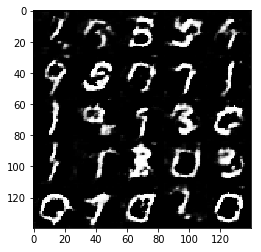

Epoch 1/2... Discriminator Loss: 0.7925... Generator Loss: 1.1155
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 0.6489... Generator Loss: 1.8217
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 2.5896
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 3.4577
Epoch 1/2... Discriminator Loss: 0.9023... Generator Loss: 2.5387
Epoch 1/2... Discriminator Loss: 1.7286... Generator Loss: 0.3665
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 0.7129... Generator Loss: 1.4612


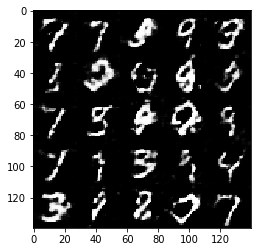

Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.1663
Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 2.9526
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 1.3319
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 3.0563
Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 0.3967
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 0.9302
Epoch 1/2... Discriminator Loss: 1.1897... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 2.2669
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 0.6061


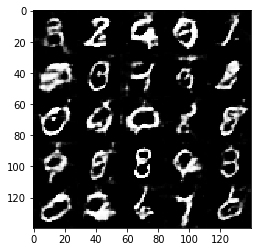

Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 1.0620
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.1873
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 1.9255
Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 0.7164... Generator Loss: 1.1614
Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 1.2735
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 1.6824
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 0.7448... Generator Loss: 1.7681


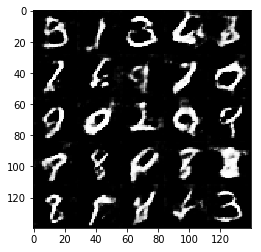

Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.4433
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 0.7831
Epoch 1/2... Discriminator Loss: 0.8257... Generator Loss: 1.0692
Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 0.7502
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 1.1347
Epoch 2/2... Discriminator Loss: 1.1222... Generator Loss: 1.0792
Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 1.1516
Epoch 2/2... Discriminator Loss: 1.0504... Generator Loss: 0.7334


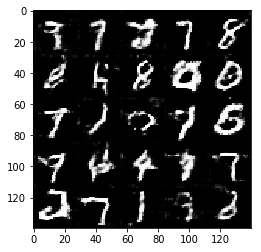

Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 2.5477
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 1.1063
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.1840
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 1.0885... Generator Loss: 2.2156
Epoch 2/2... Discriminator Loss: 0.8848... Generator Loss: 1.2367
Epoch 2/2... Discriminator Loss: 0.8540... Generator Loss: 1.4157
Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 0.9470
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.4306... Generator Loss: 0.3853


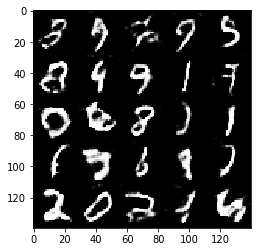

Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 1.0368... Generator Loss: 0.9050
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 2.3575
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.4745
Epoch 2/2... Discriminator Loss: 0.6586... Generator Loss: 1.4663
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.0688... Generator Loss: 1.6947
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.5435
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.4774
Epoch 2/2... Discriminator Loss: 0.9334... Generator Loss: 0.8180


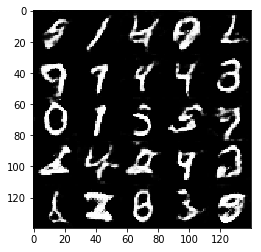

Epoch 2/2... Discriminator Loss: 0.9076... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.6508
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 1.0970
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 3.8507... Generator Loss: 5.0072
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 1.5337


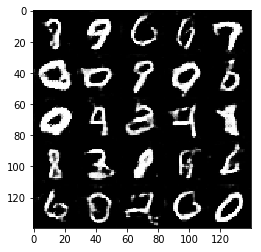

Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 1.3771
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.5637
Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.0709... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.3967
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 1.9708
Epoch 2/2... Discriminator Loss: 1.0632... Generator Loss: 1.8639


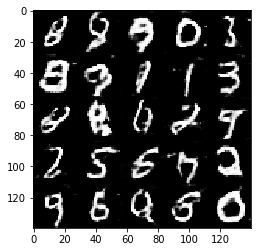

Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.4124
Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.1052
Epoch 2/2... Discriminator Loss: 1.7988... Generator Loss: 2.6826
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.1664
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 1.0583... Generator Loss: 1.1392
Epoch 2/2... Discriminator Loss: 0.7874... Generator Loss: 1.3490
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 0.9274
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.5695


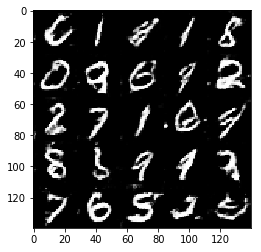

Epoch 2/2... Discriminator Loss: 1.7508... Generator Loss: 0.3573
Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 0.4786
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 1.7327... Generator Loss: 2.9853
Epoch 2/2... Discriminator Loss: 0.9743... Generator Loss: 0.8102
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 2.4095
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 1.9190
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 1.4929
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 0.6171


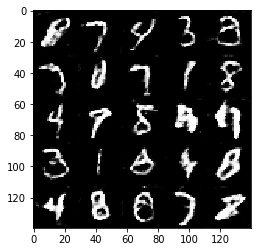

Epoch 2/2... Discriminator Loss: 0.8621... Generator Loss: 2.2166
Epoch 2/2... Discriminator Loss: 1.0897... Generator Loss: 0.6559
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.2412
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.4099
Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 1.3701
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.8996
Epoch 2/2... Discriminator Loss: 0.8028... Generator Loss: 1.5285
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 0.5870


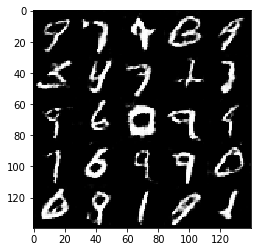

Epoch 2/2... Discriminator Loss: 0.6384... Generator Loss: 1.1957
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.5631
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.5940
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 1.6505
Epoch 2/2... Discriminator Loss: 1.5757... Generator Loss: 2.9452
Epoch 2/2... Discriminator Loss: 0.6722... Generator Loss: 1.3471
Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 2.0570... Generator Loss: 4.1840
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.0585


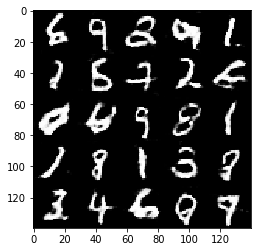

Epoch 2/2... Discriminator Loss: 0.5238... Generator Loss: 1.2469
Epoch 2/2... Discriminator Loss: 1.7171... Generator Loss: 0.3349
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 2.5640
Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.9403
Epoch 2/2... Discriminator Loss: 0.8125... Generator Loss: 1.6418
Epoch 2/2... Discriminator Loss: 0.6521... Generator Loss: 1.2662
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 0.4948


In [48]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 12.5135
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.9206
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 4.1858
Epoch 1/1... Discriminator Loss: 4.4986... Generator Loss: 0.1055
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 4.2137... Generator Loss: 0.2049
Epoch 1/1... Discriminator Loss: 2.7143... Generator Loss: 0.1503
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.0976
Epoch 1/1... Discriminator Loss: 0.0654... Generator Loss: 4.9708
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 5.7878


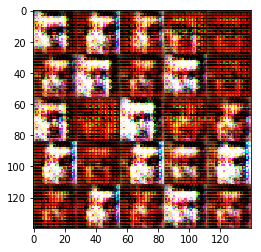

Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 4.3258
Epoch 1/1... Discriminator Loss: 0.1251... Generator Loss: 5.3909
Epoch 1/1... Discriminator Loss: 0.0599... Generator Loss: 3.5350
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 7.3962
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 2.4612
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.3891
Epoch 1/1... Discriminator Loss: 0.1812... Generator Loss: 5.7709
Epoch 1/1... Discriminator Loss: 0.3057... Generator Loss: 5.2145
Epoch 1/1... Discriminator Loss: 5.5188... Generator Loss: 9.6704
Epoch 1/1... Discriminator Loss: 0.3295... Generator Loss: 1.6955


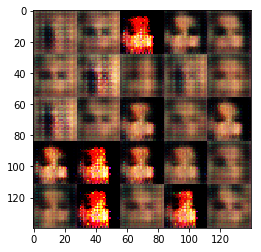

Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.2493
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 1.2373
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 1.7487
Epoch 1/1... Discriminator Loss: 0.1070... Generator Loss: 2.7517
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 2.3576
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 0.2864... Generator Loss: 2.0049
Epoch 1/1... Discriminator Loss: 5.0671... Generator Loss: 9.8169


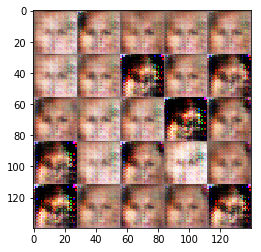

Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.4272
Epoch 1/1... Discriminator Loss: 0.1060... Generator Loss: 4.6996
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 1.8576
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 1.8774
Epoch 1/1... Discriminator Loss: 1.8005... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 2.0439
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.8201
Epoch 1/1... Discriminator Loss: 1.7163... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.2590


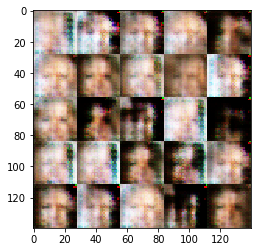

Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 2.5252
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.3199
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.7244... Generator Loss: 2.3038
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 0.9696


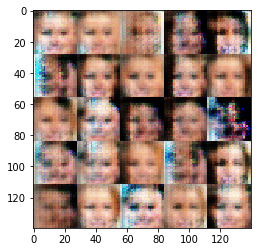

Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 1.6523
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 1.3827
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 1.6774... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 1.4213
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 0.9393


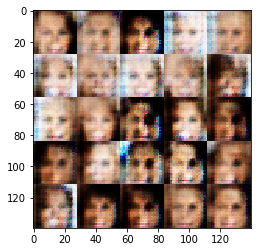

Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 1.5948
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.8069... Generator Loss: 0.3255
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.3139
Epoch 1/1... Discriminator Loss: 1.6262... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 2.4976
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.9527


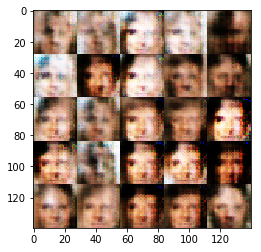

Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 2.1610... Generator Loss: 3.5329
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 2.5208
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 2.3128
Epoch 1/1... Discriminator Loss: 1.7956... Generator Loss: 0.3051
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.3105


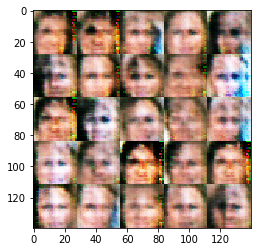

Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 1.8119... Generator Loss: 0.2961
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.1779
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 2.3489
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.0099


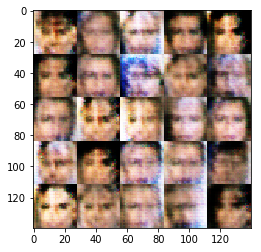

Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.5594
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.9576
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.3642


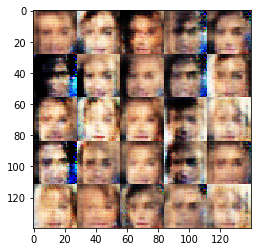

Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 2.3271... Generator Loss: 3.2034
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.0682


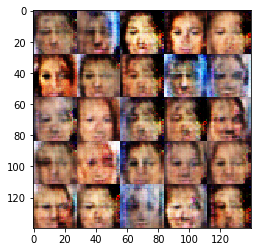

Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.9877... Generator Loss: 0.2857
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.5897
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.6278... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.6289


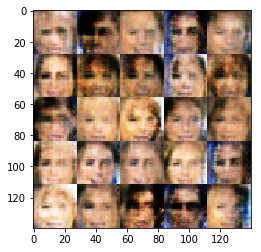

Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 2.1487
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 0.3066


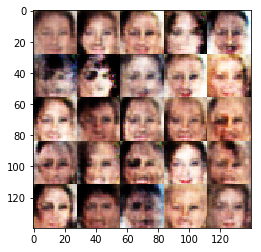

Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.1531


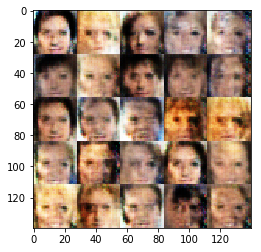

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.4205
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.3447
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 1.4923
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 2.3270


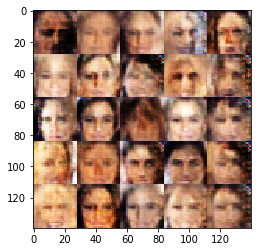

Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 1.4019
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 0.3225
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8971


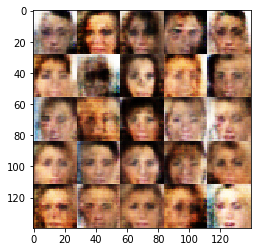

Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 1.9048... Generator Loss: 2.2179


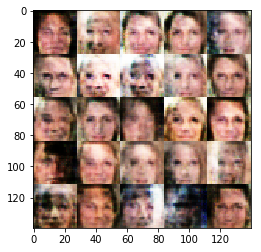

Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.3605


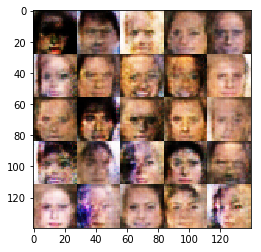

Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.7667
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.4757
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 2.1659


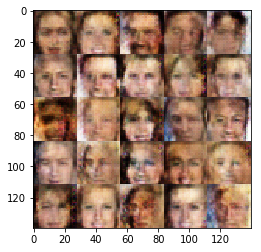

Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.3265
Epoch 1/1... Discriminator Loss: 1.7337... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.3843
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.7615


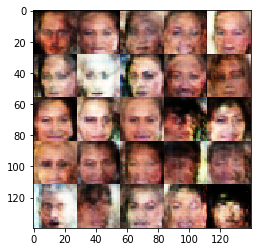

Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.9555
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 1.2702


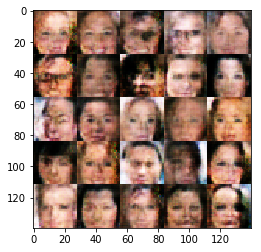

Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.4777
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.3193
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 3.2094
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.4563


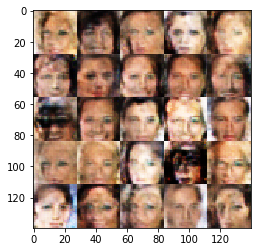

Epoch 1/1... Discriminator Loss: 1.7427... Generator Loss: 1.9303
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.3682
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 1.6239
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.7029


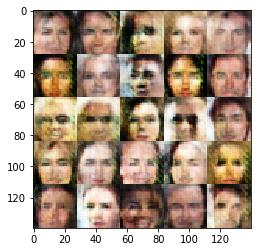

Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 2.0588
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 2.0055


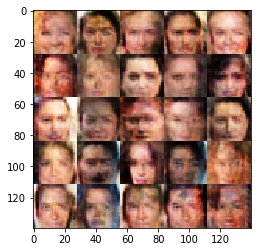

Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.8289... Generator Loss: 0.2580
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.9820


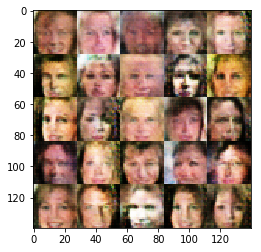

Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.9393
Epoch 1/1... Discriminator Loss: 1.7359... Generator Loss: 2.6108
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.6816
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 0.9130


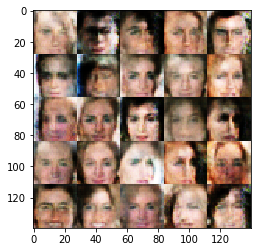

Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.5948
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.5000
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.4289
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.6927


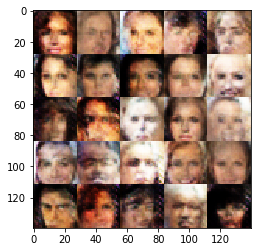

Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 2.1805
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.4464
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.7591
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.5302


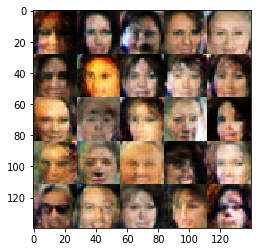

Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.9336
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 1.1517
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 1.3584
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 2.3946
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.6086


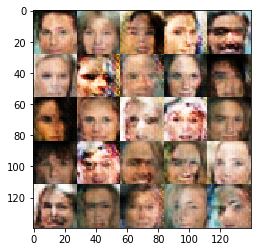

Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 2.0954
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.6362
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 0.7851


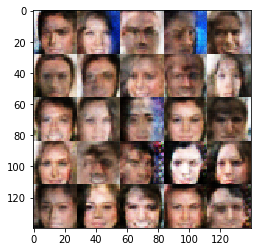

Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.9197
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.0508


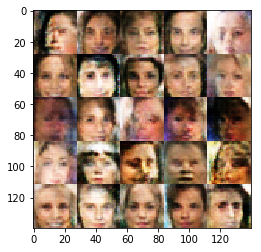

Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 1.8396
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.1839


In [49]:
batch_size = 64
z_dim = 128
learning_rate = .002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.